In [2]:
import tensorflow as tf

# Check if the GPU is available
print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

2.15.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-02 17:05:29.698168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 17:05:29.713859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 17:05:29.713887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
important_families = ['lachnospiraceae', 'ruminococcaceae', 'rikenellaceae', 'porphyromonadaceae', 'prevotellaceae', 'bacteroidaceae', 'bifidobacteriaceae', 'coriobacteriaceae', 'veillonellaceae', 'clostridiaceae', 'enterobacteriaceae', 'streptococcaceae', 'peptostreptococcaceae', 'pasteurellaceae', 'acidaminococcaceae', 'verrucomicrobiaceae', 'desulfovibrionaceae', 'erysipelotrichaceae', 'sutterellaceae', 'victivallaceae']
len(important_families)

20

In [4]:
from Bio import SeqIO
otus_file = '../PRJNA594535_unifrac/zotus.fa'

# Find the shortes otu sequence
seq_lengths = []
with open(otus_file, 'r') as f:
    for record in SeqIO.parse(f, 'fasta'):
        seq_lengths.append(len(str(record.seq)))
min_length = min(seq_lengths)
min_length

250

In [32]:
import gzip
from Bio import SeqIO
import re

# Function to load FASTA sequences and taxonomic annotations
def parse_data(fasta_file, taxonomy_file):
    sequences = []
    labels = []
    others_count = 0
    
    # Load taxonomy data into a dictionary for quick lookup
    taxonomy_dict = {}
    with gzip.open(taxonomy_file, 'rt') as f:
        for line in f:
            fields = line.strip().split('\t')
            accession = fields[0]
            taxonomy = fields[1]
            taxonomy_dict[accession] = taxonomy
    
    # Load sequences and labels
    with gzip.open(fasta_file, 'rt') as f:
        for record in SeqIO.parse(f, 'fasta'):
            accession = record.id
            if accession in taxonomy_dict:
                try:
                    family = re.search(r'f__([a-z]+)', taxonomy_dict[accession].lower()).group(1)
                except:
                    print('Error', taxonomy_dict[accession])
                    continue
                if family in important_families:
                    sequences.append(str(record.seq))
                    taxonomy = taxonomy_dict[accession]
                    labels.append(family)  # Extract family level taxonomy
                elif others_count < 50000:
                    sequences.append(str(record.seq))
                    taxonomy = taxonomy_dict[accession]
                    labels.append('others')
                    others_count += 1
    
    with open('sequences_small_partitions.txt', 'w') as f:
        for sequence, label in zip(sequences, labels):
            for i in range(0, len(sequence), min_length):
                fragment = sequence[i:i+min_length]
                if len(fragment) == min_length:
                    f.write(fragment + '\t' + label + '\n')

# Load data
fasta_file = 'gg_12_10.fasta.gz'
taxonomy_file = 'gg_12_10_taxonomy.txt.gz'
parse_data(fasta_file, taxonomy_file)

Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Proteobacteria; c__Deltaprot

In [4]:
# Read the text file with the sequences and take 50.000 random samples per label
import pandas as pd

sequences_df = pd.read_csv('sequences_small_partitions.txt', sep='\t', names=['sequence', 'family'])

# Take a random sample of 50,000 records for each of those families
sampled_data = pd.DataFrame()
for family, count in sequences_df['family'].value_counts().items():
    family_data = sequences_df[sequences_df['family'] == family]
    if count > 40000:
        sampled_data = pd.concat([sampled_data, family_data.sample(n=40000, random_state=42)])
    else:
        sampled_data = pd.concat([sampled_data, family_data])

# Display the sampled data
sampled_data.sample(frac=1, random_state=10).to_csv('sampled_sequences.txt', sep='\t', index=False)
sampled_data.groupby('family').size()

family
bacteroidaceae           40000
bifidobacteriaceae        4897
clostridiaceae           40000
coriobacteriaceae        10722
desulfovibrionaceae       9947
enterobacteriaceae       40000
erysipelotrichaceae      19655
lachnospiraceae          40000
others                   40000
pasteurellaceae          40000
peptostreptococcaceae    16538
porphyromonadaceae       35198
prevotellaceae           40000
rikenellaceae             7357
ruminococcaceae          40000
streptococcaceae         40000
veillonellaceae          40000
verrucomicrobiaceae      11756
victivallaceae             430
dtype: int64

In [5]:
import pandas as pd

dataset = pd.read_csv('sampled_sequences.txt', sep='\t')
dataset.head()

sequence              family
0  GTAGCCGGCCTGAGAGGGCGACCGGCCACACTGGGACTGAGACACG...              others
1  GATGAACGCTAGCTACAGGCTTAACACATGCAAGTCGAGGGGCATC...      bacteroidaceae
2  AGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTATCCGGATTTACT...     lachnospiraceae
3  AGGCACGAAGGCGTGGGGATCAAACAGGATTAGATACCCTGGTAGT...  porphyromonadaceae
4  CTGGCGGCGTGCTTAACACATGCAAGTCGAACGATTAGCGATGGAA...     veillonellaceae

In [6]:
dataset.groupby('family').size()

family
bacteroidaceae           40000
bifidobacteriaceae        4897
clostridiaceae           40000
coriobacteriaceae        10722
desulfovibrionaceae       9947
enterobacteriaceae       40000
erysipelotrichaceae      19655
lachnospiraceae          40000
others                   40000
pasteurellaceae          40000
peptostreptococcaceae    16538
porphyromonadaceae       35198
prevotellaceae           40000
rikenellaceae             7357
ruminococcaceae          40000
streptococcaceae         40000
veillonellaceae          40000
verrucomicrobiaceae      11756
victivallaceae             430
dtype: int64

In [7]:
# Keras text tokenizer
import keras_nlp

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=['A', 'C', 'G', 'T', 'N'],
    oov_token='N',
    special_tokens=['A', 'C', 'G', 'T'],
    special_tokens_in_strings=True,
    sequence_length=min_length
)

2024-05-02 17:05:44.043854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 17:05:44.043899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 17:05:44.043914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 17:05:44.693767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 17:05:44.693802: I external/local_xla/xla/stream_executor

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(dataset['family'])
num_classes = len(label_encoder.classes_)

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)

In [9]:
# data split
from sklearn.model_selection import train_test_split

X_train_valid, X_test, y_train_valid, y_test = train_test_split(dataset['sequence'], labels_one_hot, test_size=0.2, random_state=13)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=68)

In [10]:
import tensorflow as tf

# Create a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Tokenize text and pad sequences
train_dataset = train_dataset.map(lambda text, label: (tokenizer.tokenize(text), label))
valid_dataset = valid_dataset.map(lambda text, label: (tokenizer.tokenize(text), label))
test_dataset = test_dataset.map(lambda text, label: (tokenizer.tokenize(text), label))

# Batch and prefetch the dataset
batch_size = 512
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
# Define the model
import tensorflow as tf
from tensorflow.keras import layers

# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=3,
    min_delta=0.001,
    restore_best_weights=True,
)
# Save the model with the minimum validation loss
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_lstm3.keras',
    save_best_only=True,
)

model = tf.keras.Sequential([
    layers.Embedding(input_dim=tokenizer.vocabulary_size(), output_dim=64),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
model.fit(
    train_dataset,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint],
    validation_data=valid_dataset
)

2024-05-02 17:06:33.429990: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/30


2024-05-02 17:06:35.073000: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-02 17:06:35.587865: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8bdc0f98a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-02 17:06:35.587889: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-05-02 17:06:35.590844: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714687595.634598   30414 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


646/646 [==============================] - 27s 39ms/step - loss: 1.4870 - accuracy: 0.5391 - val_loss: 0.5758 - val_accuracy: 0.8320
Epoch 2/30
646/646 [==============================] - 25s 39ms/step - loss: 0.4297 - accuracy: 0.8751 - val_loss: 0.2954 - val_accuracy: 0.9149
Epoch 3/30
646/646 [==============================] - 25s 39ms/step - loss: 0.2716 - accuracy: 0.9219 - val_loss: 0.2301 - val_accuracy: 0.9338
Epoch 4/30
646/646 [==============================] - 25s 38ms/step - loss: 0.2144 - accuracy: 0.9389 - val_loss: 0.1768 - val_accuracy: 0.9502
Epoch 5/30
646/646 [==============================] - 25s 39ms/step - loss: 0.1696 - accuracy: 0.9520 - val_loss: 0.1447 - val_accuracy: 0.9594
Epoch 6/30
646/646 [==============================] - 25s 39ms/step - loss: 0.1524 - accuracy: 0.9568 - val_loss: 0.1353 - val_accuracy: 0.9621
Epoch 7/30
646/646 [==============================] - 25s 38ms/step - loss: 0.1329 - accuracy: 0.9625 - val_loss: 0.1218 - val_accuracy: 0.9661
Epo

In [12]:
# Load the model
model = tf.keras.models.load_model('best_model_lstm3.keras')

In [13]:
preds = model.predict(test_dataset)

202/202 [==============================] - 4s 17ms/step


In [14]:
# Evaluate accuracy
from sklearn.metrics import accuracy_score
import numpy as np

y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy_score(y_true, y_pred)

0.9875701839303

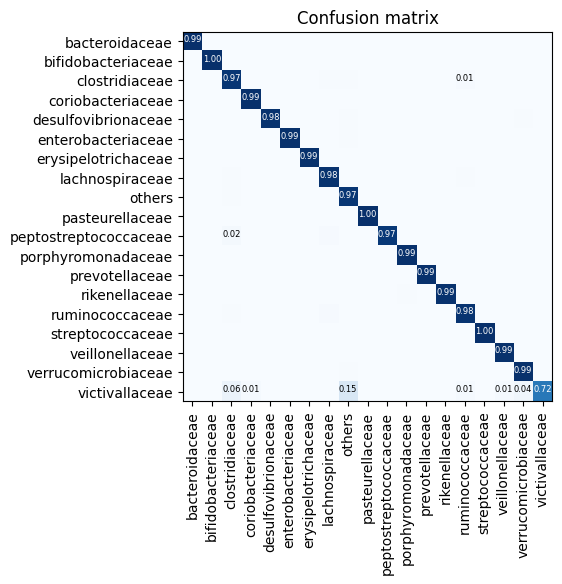

In [15]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
# Add values to confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] > 0.01:
            plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment='center', color='white' if cm[i, j] > 0.5 else 'black', fontsize=6)
# Add labels to confusion matrix
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=90)
plt.yticks(tick_marks, label_encoder.classes_)
plt.show()

# Predict the families in the zotu table

In [16]:
from Bio import SeqIO

# Function to load FASTA sequences and taxonomic annotations
zotus_data = {'id': [], 'seq': []}
with open('../PRJNA594535_unifrac/zotus.fa', 'r') as f:
    for record in SeqIO.parse(f, 'fasta'):
        zotu_id = record.id
        zotus_data['id'].append(zotu_id)
        zotus_data['seq'].append(str(record.seq))

In [17]:
processed_data = tokenizer(zotus_data['seq'])

In [18]:
processed_data.shape

TensorShape([4208, 250])

In [19]:
predictions = model.predict(processed_data)

132/132 [==============================] - 2s 10ms/step


In [20]:
import numpy as np
# Parse the predictions
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

In [21]:
zotus_data['family'] = predicted_labels

In [22]:
import pandas as pd

df_zotus = pd.DataFrame(zotus_data)
# df_zotus.to_csv('zotus_family.csv', index=False)
df_zotus.head()

id                                                seq  \
0  Zotu1  GGGATTAGATACCCCTGTAGTCCTGGCAGTAAACGGTGCACGCTTG...   
1  Zotu2  AGGATTAGATACCCCTGTAGTCCTGGCAGTAAACGGTGCACGCTTG...   
2  Zotu3  AGGATTAGATACCCTGGTAGTCCACGCAGTAAACGATGATCACTAG...   
3  Zotu4  GGGATTAGATACCCTGGTAGTCCACGCAGTAAACGATGATCACTAG...   
4  Zotu5  AGGATTAGATACCCTGGTAGTCCACACAGTAAACGATGAATACTCG...   

                family  
0  verrucomicrobiaceae  
1  verrucomicrobiaceae  
2   porphyromonadaceae  
3   porphyromonadaceae  
4       bacteroidaceae

In [23]:
df_zotus.groupby('family').size()

family
bacteroidaceae            463
bifidobacteriaceae         13
clostridiaceae            240
coriobacteriaceae          40
desulfovibrionaceae       116
enterobacteriaceae         30
erysipelotrichaceae       144
lachnospiraceae          1380
others                    317
pasteurellaceae             7
peptostreptococcaceae      20
porphyromonadaceae        205
prevotellaceae            166
rikenellaceae             184
ruminococcaceae           795
streptococcaceae            7
veillonellaceae            58
verrucomicrobiaceae        15
victivallaceae              8
dtype: int64

In [24]:
zotu_counts_per_sample = pd.read_csv('../PRJNA594535_unifrac/zotutab.txt', sep='\t', index_col=0)
zotu_counts_per_sample.head()

SRR10615586  SRR10615577  SRR10615582  SRR10615588  SRR10615580  \
#OTU ID                                                                    
Zotu1           3978         1421         3287         1008         2658   
Zotu145          536            0           20            0            3   
Zotu40           559            0          449            0          217   
Zotu44           670            0          626            1          303   
Zotu2           3566         1509         3103         1054         2601   

         SRR10615526  SRR10615561  SRR10615578  SRR10615583  SRR10615555  ...  \
#OTU ID                                                                   ...   
Zotu1            953         1646         2962         3247          845  ...   
Zotu145            0            0            6           27            0  ...   
Zotu40             0            8          231          418            0  ...   
Zotu44             0            0          460          661            0  ...   
Zotu2            952         1457         2724         2949          889  ...   

         SRR10615571  SRR10615558  SRR10615550  SRR10615522  SRR10615529  \
#OTU ID                                                                    
Zotu1           3044         2078         1803          331         2244   
Zotu145            0            0            0            0            0   
Zotu40           270           10            1            0            1   
Zotu44           403            0            0            0            0   
Zotu2           2894         2048         1697          281         2221   

         SRR10615554  SRR10615570  SRR10615532  SRR10615575  SRR10615576  
#OTU ID                                                                   
Zotu1           1687         1084         1714         3157         3196  
Zotu145            0            0            0          158          369  
Zotu40           182            0           35            0            0  
Zotu44             0            0            0            0            0  
Zotu2           1661         1003         1601         2952         3098  

[5 rows x 71 columns]

In [25]:
zotu_counts_per_sample['family'] = [df_zotus.loc[df_zotus['id'] == x, 'family'].values[0] for x in zotu_counts_per_sample.index]
zotu_counts_per_sample.head()

SRR10615586  SRR10615577  SRR10615582  SRR10615588  SRR10615580  \
#OTU ID                                                                    
Zotu1           3978         1421         3287         1008         2658   
Zotu145          536            0           20            0            3   
Zotu40           559            0          449            0          217   
Zotu44           670            0          626            1          303   
Zotu2           3566         1509         3103         1054         2601   

         SRR10615526  SRR10615561  SRR10615578  SRR10615583  SRR10615555  ...  \
#OTU ID                                                                   ...   
Zotu1            953         1646         2962         3247          845  ...   
Zotu145            0            0            6           27            0  ...   
Zotu40             0            8          231          418            0  ...   
Zotu44             0            0          460          661            0  ...   
Zotu2            952         1457         2724         2949          889  ...   

         SRR10615558  SRR10615550  SRR10615522  SRR10615529  SRR10615554  \
#OTU ID                                                                    
Zotu1           2078         1803          331         2244         1687   
Zotu145            0            0            0            0            0   
Zotu40            10            1            0            1          182   
Zotu44             0            0            0            0            0   
Zotu2           2048         1697          281         2221         1661   

         SRR10615570  SRR10615532  SRR10615575  SRR10615576  \
#OTU ID                                                       
Zotu1           1084         1714         3157         3196   
Zotu145            0            0          158          369   
Zotu40             0           35            0            0   
Zotu44             0            0            0            0   
Zotu2           1003         1601         2952         3098   

                      family  
#OTU ID                       
Zotu1    verrucomicrobiaceae  
Zotu145      lachnospiraceae  
Zotu40                others  
Zotu44                others  
Zotu2    verrucomicrobiaceae  

[5 rows x 72 columns]

In [26]:
human_samples = ['SRR10615525', 'SRR10615523', 'SRR10615521', 'SRR10615524', 'family']
zotu_counts_per_sample[human_samples].groupby('family').sum()
# Calculate the relative abundance of each family
rel_abundance = zotu_counts_per_sample[human_samples].groupby('family').sum() / zotu_counts_per_sample[human_samples].groupby('family').sum().sum()

In [27]:
rel_abundance.columns = pd.Index(['D1_H', 'D2_H', 'D3_H', 'D4_H'])

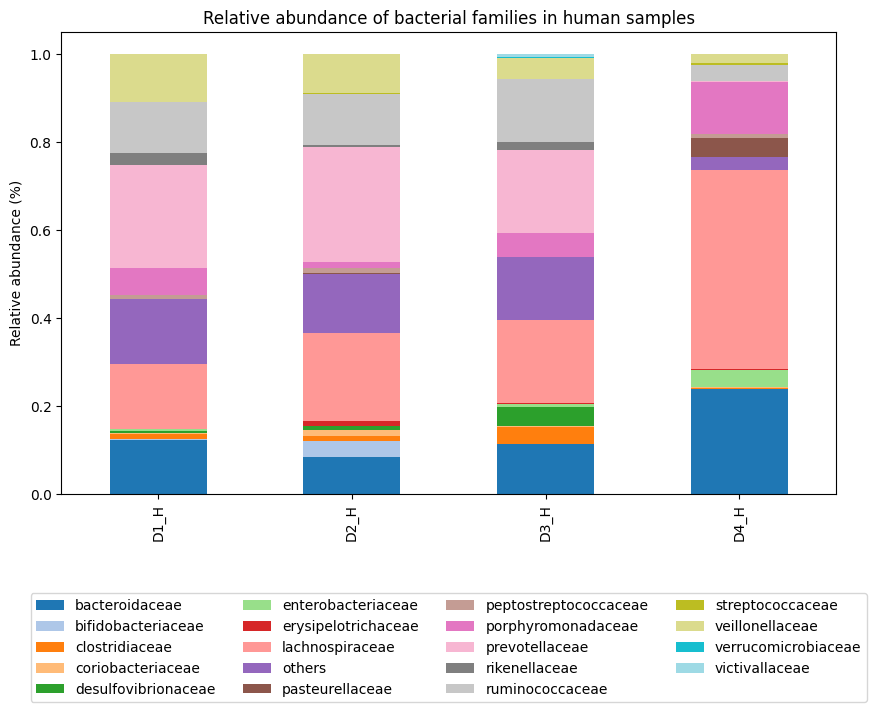

In [31]:
import matplotlib.pyplot as plt
# Plot the relative abundance of each family by sample
rel_abundance.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(10, 6))
# Add title
plt.title('Relative abundance of bacterial families in human samples')
# Add y axis label
plt.ylabel('Relative abundance (%)')
# Show legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

In [32]:
rel_abundance.to_csv('rel_abundance.csv', sep='\t')